In [45]:
import os
import numpy as np
from scipy import signal as scipysig
from matplotlib import pyplot as plt

In [100]:
def add_signal(X,
               signal_dict):
    """
    """
    n = X.shape[0]
    length = signal_dict['length'] 
    position = signal_dict['position'] + signal_dict['extra_shift']    
    amp = signal_dict['amp'] * signal_dict['sign']   
    signal_type = signal_dict['signal_type']
    
    if signal_type == 'gaussian':
        # Gaussian peak. 
        # Center of gaussian will be placed at given position.
        x0 = position - int(length/2)
        x1 = x0 + length
        dx0 = -x0*(x0<0)
        dx1 = (n - x1)*(x1 >= n)
        X[x0+dx0: x1+dx1] += amp * scipysig.gaussian(length, std=length/7)[dx0:(x1-x0+dx1)]
    elif signal_type == 'wave':
        # Two gaussian peaks in different directions ("wave"). 
        # Center will be placed at given position.
        x0 = position - int(length/2)
        x1 = x0 + length
        dx0 = -x0*(x0<0)
        dx1 = (n - x1)*(x1 >= n)
        signal = np.zeros((length))
        signal[:int(0.7*length)] += amp * scipysig.gaussian(int(0.7*length), std=length/10)
        signal[-int(0.7*length):] -= amp * scipysig.gaussian(int(0.7*length), std=length/10)
        X[x0+dx0: x1+dx1] += signal[dx0:(x1-x0+dx1)]
    elif signal_type == 'exponential':
        # Sudden peak + exponential decay. 
        # Peak will be placed at given position.
        x0 = position
        x1 = x0 + length
        dx1 = (n - x1)*(x1 >= n)
        X[x0: x1+dx1] += amp * scipysig.exponential(length, 0, length/5, False)[:(x1-x0+dx1)]
    elif signal_type == 'peak_exponential':
        # Peak with two exponential flanks. 
        # Center of eak will be placed at given position.
        x0 = position - int(length/2)
        x1 = x0 + length
        dx0 = -x0*(x0<0)
        dx1 = (n - x1)*(x1 >= n)
        X[x0+dx0: x1+dx1] += amp * scipysig.exponential(length, tau=length/10)[dx0:(x1-x0+dx1)]
    elif signal_type == 'triangle':
        # Triangular peak. 
        # Center of peak will be placed at given position.
        x0 = position - int(length/2)
        x1 = x0 + length
        dx0 = -x0*(x0<0)
        dx1 = (n - x1)*(x1 >= n)
        X[x0+dx0: x1+dx1] += amp * scipysig.triang(length)[dx0:(x1-x0+dx1)]
    elif signal_type == 'box':
        # Box peak. 
        # Center of peak will be placed at given position.
        x0 = position - int(length/2)
        x1 = x0 + length
        dx0 = -x0*(x0<0)
        dx1 = (n - x1)*(x1 >= n)
        X[x0+dx0: x1+dx1] += amp * np.ones((length))[dx0:(x1-x0+dx1)]
    else:
        print("Signal type not found.")
        X = None
        
    return X


def add_noise(X,
             noise_dict):
    """
    
    Args:
    -------
    X: numpy array (n_channels, n_timepoints)
        Array of timeseries to apply noise to.
    """
    n = X.shape[1]
    n_ch = X.shape[0]
    
    noise_amp = noise_dict['noise_amp']
    noise_type = noise_dict['noise_type']
        
    if noise_type == 'gaussian':
        noise = noise_amp * np.random.normal(0,1,(n_ch,n))
        return X + noise
    
    elif noise_type == 'random_walk':
        noise = noise_amp * np.random.normal(0,1,(n_ch,n))
        noise = np.array([np.sum(noise[:,:i], axis=1) for i in range(0,noise.shape[1])]).T
        return X + noise        

    
def add_shape(X,
              shape_dict):
    """
    """
    #TODO: add option to import custom function to generate any desired shape!
    
    n = X.shape[0]
    counts = np.linspace(0,1,n)
    
    # Get values from dict:
    shape_amp = shape_dict['shape_amp']
    shape_type = shape_dict['shape_type'] 
    
    if shape_type == 'cosine':
        shape_iter = shape_dict['shape_iter']
        shape_shift = shape_dict['shape_shift']
        shape = np.cos((counts - shape_shift)* np.pi * 2 * shape_iter)
        return X + shape_amp * shape
    elif shape_type == 'exponential':
        shape_decay = shape_dict['shape_decay']
        shape = np.exp(- shape_decay * counts)
        return X * (1 - shape_amp) + X * shape_amp * shape
    else:
        return X 
        

In [85]:
def generate_TS(TS_dict,
                random_seed = None,
                ignore_noise = False):
    """
    
    Args:
    --------
    ignore_noise: bool
        If True noise will not be added to the time series. 
        (e.g. for displaying purposes)
    """
    
    # Reset random seed 
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n = TS_dict['n_timepoints']
    n_channels = TS_dict['n_channels']             
    X = np.zeros((n_channels, n))
    
    if 'signal_defs' in TS_dict:
        for signal_def in TS_dict['signal_defs']:
            for signal_dict in generate_signals(signal_def):
                for ch in signal_dict['ch']:
                    X[ch,:] = add_signal(X[ch,:], signal_dict)
    
    if 'shape_defs' in TS_dict:
        for shape_def in TS_dict['shape_defs']:
            for shape_dict in generate_shapes(shape_def):
                ch = shape_dict['ch']
                X[ch,:] = add_shape(X[ch,:], shape_dict)
        
    if 'noise_defs' in TS_dict and not ignore_noise:
        for noise_def in TS_dict['noise_defs']:
            noise_dict = generate_noise(noise_def)
            channels = noise_dict['channels']
            if channels == 'all':
                X = add_noise(X, noise_dict)
            else:
                X[channels,:] = add_noise(X[channels,:], noise_dict)

    return X

In [60]:
import matplotlib 

def plot_TS(X_ts,
            TS_def):
    """ Plot multivariate time series
    """
    n_ch = X_ts.shape[0]
    
    cmap = matplotlib.cm.get_cmap('inferno') #'Spectral')
    plt.style.use('ggplot')
    plt.figure(figsize=(10,(1+0.7 *n_ch)))
    for i in range(n_ch):
        plt.plot((X_ts[i,:] - i), color=cmap(i/n_ch))
    
    if 'class_name' in TS_def:
        title = TS_def['class_name']
    else:
        title='Generated time series'
    plt.title(title)
    plt.yticks(-np.arange(n_ch), ['channel ' + str(i) for i in range(n_ch)])
    plt.xlabel('time')

## Define classes

In [4]:
# helper functions

def random_float(a,b):
    # Get random float from range [a,b)
    return a + np.random.random(1)[0] *(b - a)

def random_int(a,b):
    # Get random integer from range [a,b] (inclusive b)
    return np.random.randint(a, b+1)

def random_choice(a,b):
    # Pick either a or b
    return np.random.choice([a, b], 1)

def interpret_parameter(param,
                        rand_function):
    """ Interpret given parameter.
    If list of two values is given a random number within this range is returned.
    Otherwise the output values will be the input value.
    """
    if isinstance(param ,list) and len(param) == 2:
        param_gen = rand_function(param[0], param[1])
    else:
        param_gen = param

    return param_gen   

In [92]:
def generate_signals(signal_def):
    """
    
    Return dict.
    """
    signal_type_gen = []
         

    #random_types = [random_int, random_int, random_int, random_float]

    # Get values from dict:
    peaks_per_ch = signal_def['peaks_per_ch']
    channels = signal_def['channels']
    if not isinstance(channels, list):
        channels = [channels]
    n_ch = signal_def['n_ch']
    length = signal_def['length']
    position = signal_def['position']
    extra_shift = signal_def['extra_shift']
    amp = signal_def['amp']
    sign = signal_def['sign']
    signal_type = signal_def['signal_type']
    
    signals_lst = []   

    # Generate number of channels
    num_ch = interpret_parameter(n_ch, random_int)

    # Select channels
    channels_select = np.random.choice(channels, num_ch, replace=False)
    
    # Generate number peaks per channel
    peaks_gen = interpret_parameter(peaks_per_ch, random_int)
    
    for i in range(peaks_gen):
        # Generate signal position
        position_gen = interpret_parameter(position, random_int)
        
        for channel in channels_select:
        
            # Generate signal length
            length_gen = interpret_parameter(length, random_int)
                
            # Generate signal extra_shift
            extra_shift_gen = interpret_parameter(extra_shift, random_int)

            # Generate signal amp
            amp_gen = interpret_parameter(amp, random_float)
                
            # Generate signal sign
            sign_gen = interpret_parameter(sign, random_choice)

            signals_lst.append({'ch' : [channel],
                                'length' : length_gen,
                                'position' : position_gen,
                                'extra_shift' : extra_shift_gen,
                                'amp' : amp_gen,
                                'sign' : sign_gen,
                                'signal_type' : signal_type
                                 })
            
    return signals_lst


def generate_noise(noise_def):
    """
    
    Return dict.
    """ 

    # Get values from dict:
    channels = noise_def['channels']
    noise_amp = noise_def['noise_amp']
    noise_type = noise_def['noise_type']  

    # Generate signal amp
    noise_amp_gen = interpret_parameter(noise_amp, random_float)

    noise_dict = {'channels' : channels,
                  'noise_amp' : noise_amp_gen,
                  'noise_type' : noise_type
                  }        
    print(noise_dict)
    return noise_dict


def generate_shapes(shape_def):
    """
    
    Return dict.
    """ 
    
    # Get values from dict:
    channels = shape_def['channels']
    if not isinstance(channels, list):
        channels = [channels]
    shape_amp = shape_def['shape_amp']
    if 'shape_iter' in shape_def:
        shape_iter = shape_def['shape_iter']
    else:
        shape_iter = 1
        
    if 'shape_shift' in shape_def:
        shape_shift = shape_def['shape_shift']
    else:
        shape_shift = 0
    
    if 'shape_decay' in shape_def:
        shape_decay = shape_def['shape_decay']
    else:
        shape_decay = 0  
    
    shape_type = shape_def['shape_type']  
                               
    shapes_lst = []
    for ch in channels:
        # Generate signal amp
        shape_amp_gen = interpret_parameter(shape_amp, random_float)

        # Generate signal iterations
        shape_iter_gen = interpret_parameter(shape_iter, random_float)

        # Generate signal decay
        shape_decay_gen = interpret_parameter(shape_decay, random_float)

        # Generate signal phase shift
        shape_shift_gen = interpret_parameter(shape_shift, random_int)
        
        shapes_lst.append({'ch' : ch,
                          'shape_amp' : shape_amp_gen,
                          'shape_type' : shape_type,
                          'shape_iter' :  shape_iter_gen,
                          'shape_shift' : shape_shift_gen,
                          'shape_decay' : shape_decay_gen
                          })

    return shapes_lst

In [113]:
def load_TS_class(filename,
                 print_info=True):
    """ Load parameters and rules from yaml file to create time series.
    
    Returns dict.
    """
    
    with open(filename, 'r') as ymlfile:
        TS_def = yaml.load(ymlfile)

    if print_info:
        print(TS_def['class_name'])
        print(TS_def['description'])
        print('n_channels:', TS_def['n_channels'])
        print('n_timepoints:', TS_def['n_timepoints'])
    
    return TS_def

In [114]:
ROOT = 'C:\\OneDrive - Netherlands eScience Center\\Project_ePodium\\time_series_generator'
PATH_classes = os.path.join(ROOT, 'TS_types')
filename = os.path.join(PATH_classes, 'TS_type_show_variety.yaml')

TS_def = load_TS_class(filename)

Show variety
This file defines a test type for time series generation. It contains a wide variety of different signals and shapes. It also applies random walk and gaussian noise.

n_channels: 11
n_timepoints: 400


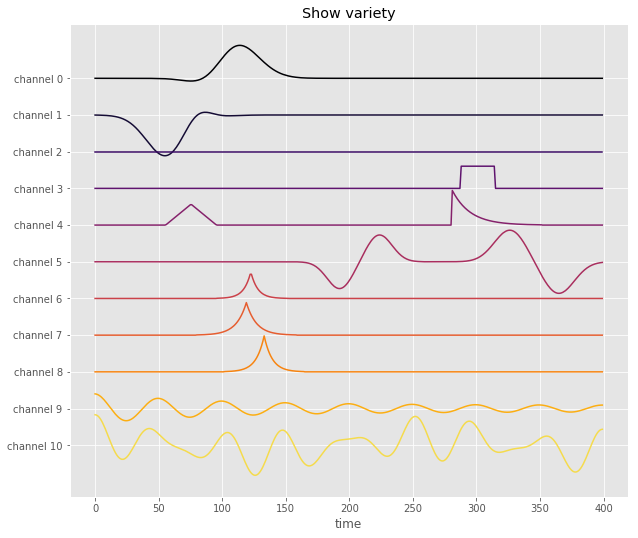

In [111]:
X = generate_TS(TS_def,
                random_seed = None,
                ignore_noise = True)

plot_TS(X, TS_def)

{'channels': 'all', 'noise_amp': 0.059335009202231184, 'noise_type': 'gaussian'}
{'channels': [0, 1, 2, 3, 4, 5, 6], 'noise_amp': 0.020348314890146282, 'noise_type': 'random_walk'}


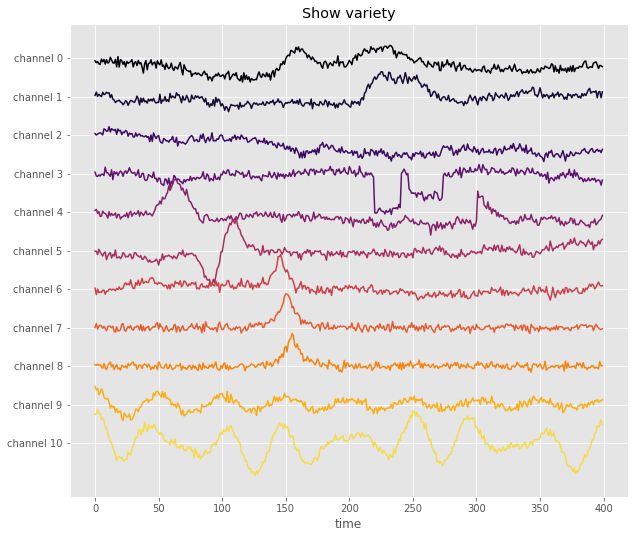

In [112]:
X = generate_TS(TS_def,
                random_seed = None)

plot_TS(X, TS_def)

In [64]:
TS_def = {'signal_defs' : [{'peaks_per_ch' : 1,
                           'channels' : [6,7,8,9],
                           'n_ch' : 3,
                           'length' : [50,80],
                           'position' : [50,160],
                           'extra_shift' : [-10,10],
                           'amp' : [0.7,1],
                           'sign' : 1,
                           'signal_type' : 'peak_exponential'
                         }],
          'noise_defs' : [{'channels' : 'all',
                           'noise_amp' : [0.05,0.06],
                          'noise_type' : 'gaussian'
                         },
                         {'channels' : 'all',
                          'noise_amp' : [0.018,0.022],
                          'noise_type' : 'random_walk'
                         }]
          }

TS_def['noise_defs'][0]

{'channels': 'all', 'noise_amp': [0.05, 0.06], 'noise_type': 'gaussian'}

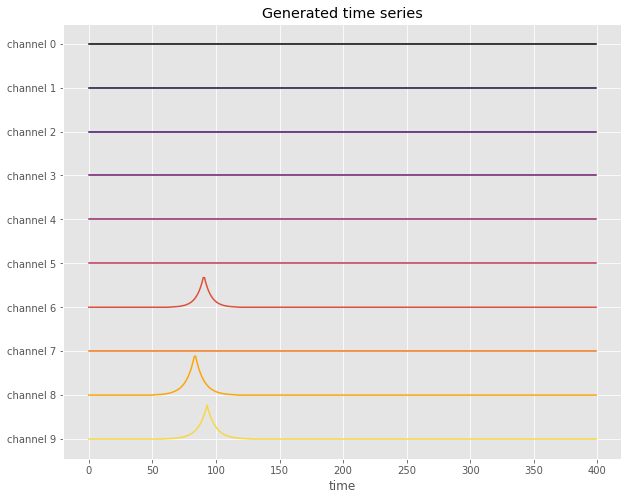

In [69]:
X = generate_TS(400,
                10,
                TS_def,
                random_seed = None,
                ignore_noise = True)
plot_TS(X, TS_def)

{'channels': 'all', 'noise_amp': 0.05720533519212013, 'noise_type': 'gaussian'}
{'channels': 'all', 'noise_amp': 0.02197580580831351, 'noise_type': 'random_walk'}


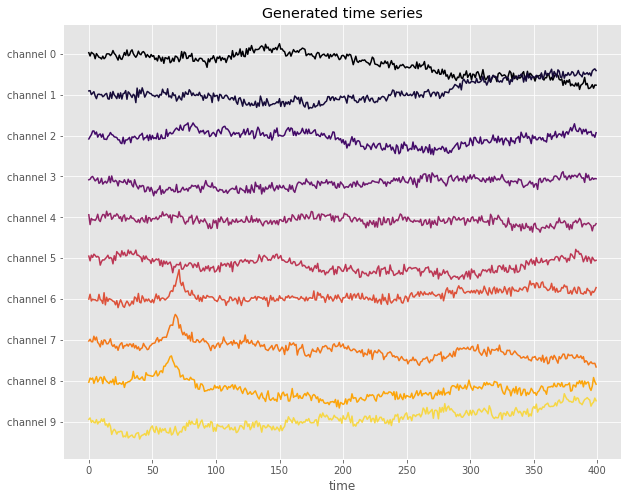

In [68]:
X = generate_TS(400,
                10,
                TS_def,
                random_seed = None)
plot_TS(X, TS_def)

In [42]:
import yaml 

with open(r'test_signal_type.yaml', 'w') as file:
    documents = yaml.dump(TS_def, file)

(13, 400)


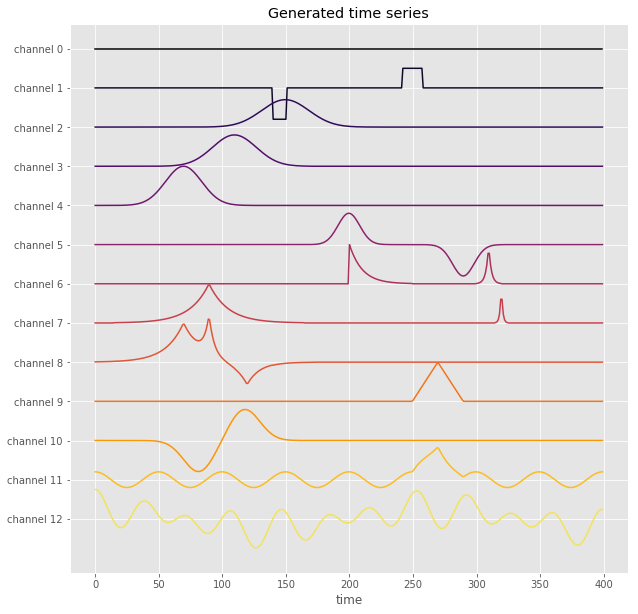

In [463]:
signal_lst = [(1, [5,20], 250, 0.5, 'box'),
              (1, [5,20], [50,350], -0.8, 'box'),
              (2, 130, 150, 0.7, 'gaussian'), 
              (3, 120, 110, 0.8, 'gaussian'), 
              (4, 100, 70, 1, 'gaussian'),
              (5, 60, 200, 0.8, 'gaussian'),
              (5, 60, 290, -0.8, 'gaussian'),
              (6, 50, 200, 1, 'exponential'),
              (6, 20, 310, 1, 'peak_exponential'),
              (7, 150, 90, 1, 'peak_exponential'),
              (7, 10, 320, 1, 'peak_exponential'),
              (8, 140, 70, 1, 'peak_exponential'),
              (8, 40, 90, 1, 'peak_exponential'),
              (8, 100, 120, -0.6, 'peak_exponential'),
              (9, 40, 270, 1, 'triangle'),
              (10, 120, 100, -0.8, 'wave'),
              (11, 40, 270, 1, 'triangle')]

noise_lst = []# [(0.02, 'random_walk'), (0.08, 'gaussian')]

shape_lst = [(11, 0.2, 'cosine', 8, 0),
            (12, 0.2, 'cosine', 8, 0),
            (12, 0.3, 'cosine', 11, -10),
            (12, 0.25, 'cosine', 1.5, -10)]

X = generate_TS(400,
                13,
                signal_lst,
                noise_lst,
                shape_lst)

print(X.shape)
plot_TS(X)

In [32]:
TS_def = {'signal_defs' : [{'peaks_per_ch' : [1,4],
                            'channels' : [0,1,2,3],
                            'n_ch' : [2,4],
                            'length' : [50,140],
                            'position' : 0,
                            'extra_shift' : [50,280],
                            'amp' : [0.5,0.7],
                            'sign' : [1, -1],
                            'signal_type' : 'gaussian'
                         },
                         {'peaks_per_ch' : [1,2],
                           'channels' : 4,
                           'n_ch' : 1,
                           'length' : [10,30],
                           'position' : 200,
                           'extra_shift' : [0,150],
                           'amp' : [0.5,1],
                           'sign' : [1, -1],
                           'signal_type' : 'box'
                         },
                         {'peaks_per_ch' : [1,2],
                           'channels' : 5,
                           'n_ch' : 1,
                           'length' : [40,140],
                           'position' : [100,350],
                           'extra_shift' : 0,
                           'amp' : [0.5,1],
                           'sign' : [1, -1],
                           'signal_type' : 'wave'
                         },
                         {'peaks_per_ch' : 1,
                           'channels' : [6,7,8],
                           'n_ch' : 3,
                           'length' : [50,80],
                           'position' : [50,160],
                           'extra_shift' : [-10,10],
                           'amp' : [0.7,1],
                           'sign' : 1,
                           'signal_type' : 'peak_exponential'
                         }],
          'noise_defs' : [{'channels' : 'all',
                           'noise_amp' : [0.05,0.06],
                          'noise_type' : 'gaussian'
                         },
                         {'channels' : [0,1,2,3,4,5,6,7],
                          'noise_amp' : [0.018,0.022],
                          'noise_type' : 'random_walk'
                         }],
          'shape_defs' : [{'channels' : [9, 10], 
                           'shape_amp' : 0.2, 
                           'shape_type' : 'cosine',
                           'shape_iter' :  8,
                           'shape_shift' : 0
                          },
                          {'channels' : [10], 
                           'shape_amp' : [0.2, 0.3], 
                           'shape_type' : 'cosine',
                           'shape_iter' :  11,
                           'shape_shift' : -10
                          }]
          }

TS_def['noise_defs'][0]

{'channels': 'all', 'noise_amp': [0.05, 0.06], 'noise_type': 'gaussian'}

(13, 400)


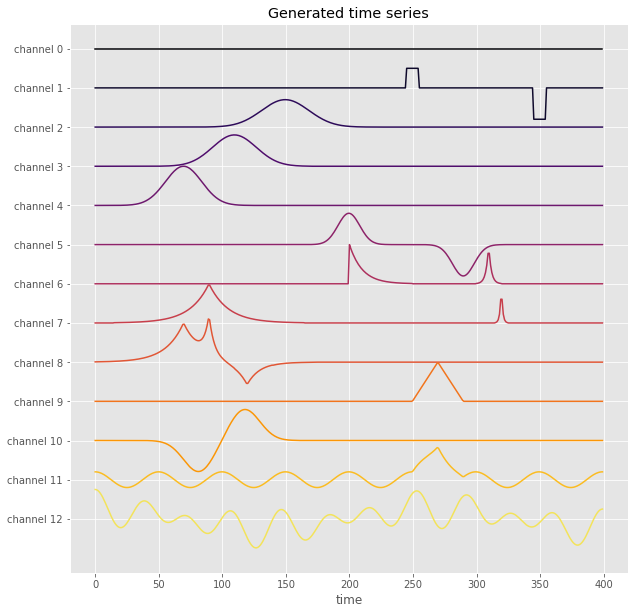

In [458]:
signal_lst = [(1, 10, 250, 0.5, 'box'),
              (1, 10, 350, -0.8, 'box'),
              (2, 130, 150, 0.7, 'gaussian'), 
              (3, 120, 110, 0.8, 'gaussian'), 
              (4, 100, 70, 1, 'gaussian'),
              (5, 60, 200, 0.8, 'gaussian'),
              (5, 60, 290, -0.8, 'gaussian'),
              (6, 50, 200, 1, 'exponential'),
              (6, 20, 310, 1, 'peak_exponential'),
              (7, 150, 90, 1, 'peak_exponential'),
              (7, 10, 320, 1, 'peak_exponential'),
              (8, 140, 70, 1, 'peak_exponential'),
              (8, 40, 90, 1, 'peak_exponential'),
              (8, 100, 120, -0.6, 'peak_exponential'),
              (9, 40, 270, 1, 'triangle'),
              (10, 120, 100, -0.8, 'wave'),
              (11, 40, 270, 1, 'triangle')]

noise_lst = []# [(0.02, 'random_walk'), (0.08, 'gaussian')]

shape_lst = [(11, 0.2, 'cosine', 8, 0),
            (12, 0.2, 'cosine', 8, 0),
            (12, 0.3, 'cosine', 11, -10),
            (12, 0.25, 'cosine', 1.5, -10)]

X = generate_TS(400,
                13,
                signal_lst,
                noise_lst,
                shape_lst)

print(X.shape)
plot_TS(X)

(13, 400)


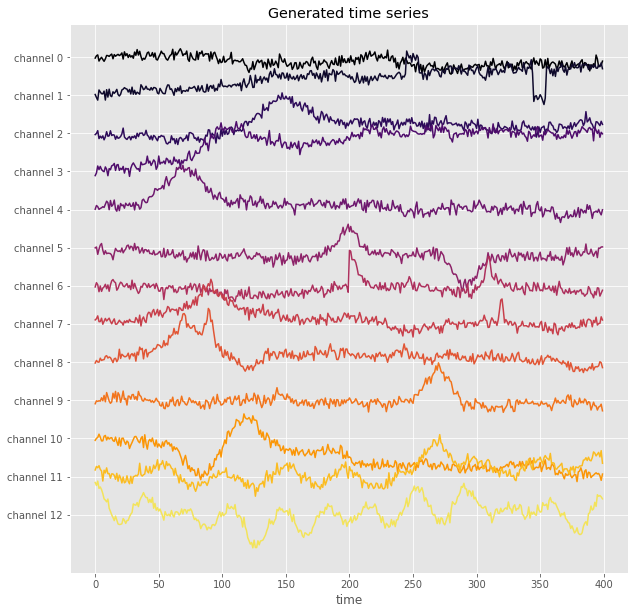

In [358]:
noise_lst = [(0.02, 'random_walk'), (0.08, 'gaussian')]

X = generate_TS(400,
                13,
                signal_lst,
                noise_lst,
                shape_lst,
                random_seed = 40)

print(X.shape)
plot_TS(X)